## 피드백

가설을 정하고 검증을 해도 사후적으로 인사이트를 만들 수 있다

EDA를 심도있게 - 데이터 간의 관계를 조금 더 살펴볼 수 있도록

과적합 등이 일어나지 않게 안정적인 모델을 추구할 것

shap value, feature importance 가 중요한 col을 증명하는 근거가 됨

test.csv 를 통한 prediction에서도 위의 근거가 일치하는지, 아닌지 확인해볼 것..

일치하지 않는다면 모델링을 다시 해볼 것.

unknown --------> 얘네들만 모아서 특성을 살펴보고 대치할 방법을 찾아볼 것

1. 제거하기

2. 대치하기 - regression(근로기간 ~ 나머지 X 변수), 유사한 기간으로 대치하기, 다른 값..


내일 역할 분담해서 EDA 하기

In [8]:
df = pd.read_csv('train.csv')

In [9]:
len(df[df['근로기간'] == 'Unknown'])

5671

### 02/07 정리
### 높은 등급의 특징

아래 특징의 비율이 등급이 높을수록 높았음

아래 특징들을 바탕으로 파생변수를 만들 수 있을 거 같음

- 대출기간 : 단기

- 근로기간 : 장기

- 주택상태 : 전세

- 대출목적 : 부채통합

---------------------------------------------------------

부채_대비_소득_비율 : 4분위수 사용해서 이상치 제거

연간소득 : 4분위수 사용해서 이상치 제거

총상환원금 : 4분위수 사용해서 이상치 제거

총상환이자 : 4분위수 사용해서 이상치 제거

총계좌수 : 4분위수 사용해서 이상치 제거

스캐일러 정하기

MinMax

Standard


---------------------------------------------------------

근로기간 : unknown = 5년으로

주택소유상태 : any 삭제


인코딩

onehot - 대출기간, 주택소유상태, 대출목적

label - 근로기간


---------------------------------------------------------


모델
다중분류 모델
sklearn.cluster.Kmeans
randomforestclassifier()
의사결정나무classifier()


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sidetable

import warnings
warnings.filterwarnings(action='ignore')

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [96]:
df = pd.read_csv('train.csv')

df = df.drop(index=df[df['주택소유상태'] == 'ANY'].index)


In [97]:
df_un = df[df['근로기간'] == 'Unknown']
df_n = df[df['근로기간'] != 'Unknown']

In [75]:
df_n['대출등급'].value_counts().sort_index()

A    15838
B    27075
C    25995
D    12482
E     6976
F     1862
G      395
Name: 대출등급, dtype: int64

In [93]:
g = df_n[df_n['대출등급'] == 'G']

In [94]:
feature_col = ['대출기간', '주택소유상태', '대출목적', '근로기간']

for col in feature_col:
    print(col)
    display((g[col].value_counts()/len(g[col])).sort_values(ascending=False))

대출기간


 60 months    0.868354
 36 months    0.131646
Name: 대출기간, dtype: float64

주택소유상태


RENT        0.478481
MORTGAGE    0.402532
OWN         0.118987
Name: 주택소유상태, dtype: float64

대출목적


부채 통합     0.632911
기타        0.106329
소규모 사업    0.073418
주택 개선     0.063291
신용 카드     0.040506
주택        0.027848
주요 구매     0.017722
이사        0.012658
의료        0.012658
자동차       0.010127
휴가        0.002532
Name: 대출목적, dtype: float64

근로기간


10    0.346835
1     0.139241
3     0.098734
2     0.091139
4     0.063291
5     0.060759
7     0.055696
8     0.050633
6     0.048101
9     0.045570
Name: 근로기간, dtype: float64

In [42]:
print(len(df_n), len(df_un))

90623 5671


In [98]:
def year_encoder(x):
    output = x.replace('years', '')
    output = output.replace('year', '')
    output = output.replace('+', '')
    output = output.replace('<', '')
    output = output.replace('Unknown', '-1').strip()
    output = int(output)

    return output

In [99]:
df_n['근로기간'] = df_n['근로기간'].apply(year_encoder)

In [100]:
work_year = list(df_n['근로기간'].unique())
work_year = sorted(work_year)
work_year

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [101]:
numeric_col = ['대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수', '근로기간']
category_col = ['대출기간', '주택소유상태', '대출목적']

In [102]:
un_duration = (df_un['대출기간'].value_counts() / df_un['대출기간'].value_counts().values.sum()).sort_index()
un_house = (df_un['주택소유상태'].value_counts() / df_un['주택소유상태'].value_counts().values.sum()).sort_index()
un_purpose = (df_un['대출목적'].value_counts() / df_un['대출목적'].value_counts().values.sum()).sort_index()

un_feature = [un_duration, un_house, un_purpose]

In [73]:
df_n['근로기간'].mean()

6.097657327609989

In [103]:
category_col = ['대출기간', '주택소유상태', '대출목적']
un_feature = [un_duration, un_house, un_purpose]

sses = []

for year in work_year:
    sse_list = []
    
    temp = df_n[df_n['근로기간'] == year]
    
    for i, col in enumerate(category_col):
        feature = temp[col]
        data = (feature.value_counts() / feature.value_counts().values.sum()).sort_index()
        
        error = data - un_feature[i]
        
        se = error ** 2
        
        sse_list.append(se.values.sum())
    
    print(f'{year} year sse : {sum(sse_list)}')
    
    

1 year sse : 0.08399583025845522
2 year sse : 0.07190508612749433
3 year sse : 0.06159008675635343
4 year sse : 0.05467022524137271
5 year sse : 0.053712302901496214
6 year sse : 0.05586308248683839
7 year sse : 0.061069597406554745
8 year sse : 0.07573488422007825
9 year sse : 0.07951786610598383
10 year sse : 0.09956440428708312


In [69]:
df_n[df_n['근로기간'] == 10]['대출기간'].value_counts()

 36 months    20563
 60 months    11918
Name: 대출기간, dtype: int64

work_year : 1


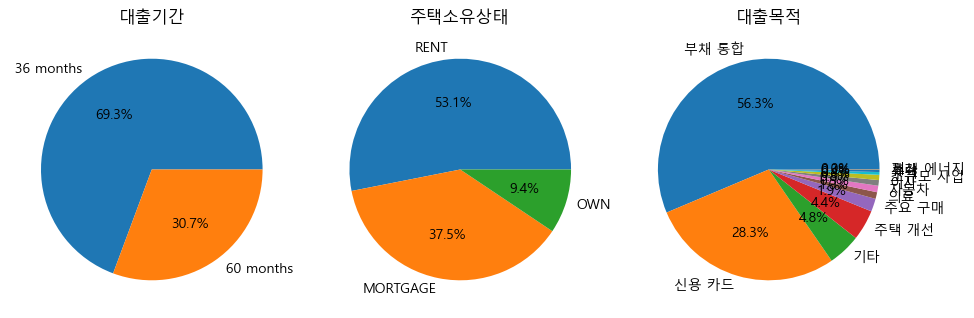

work_year : 2


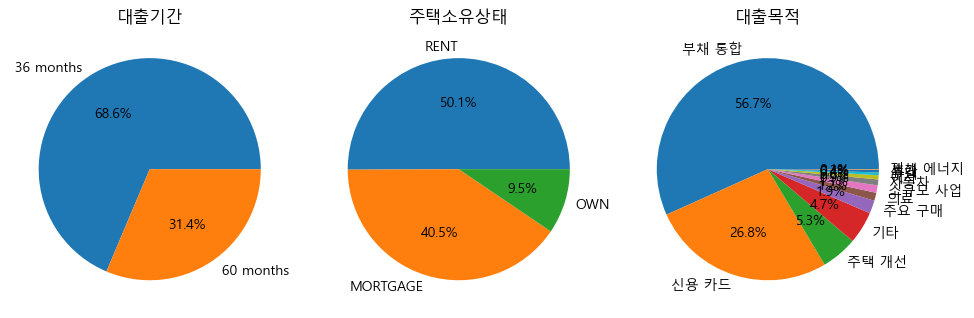

work_year : 3


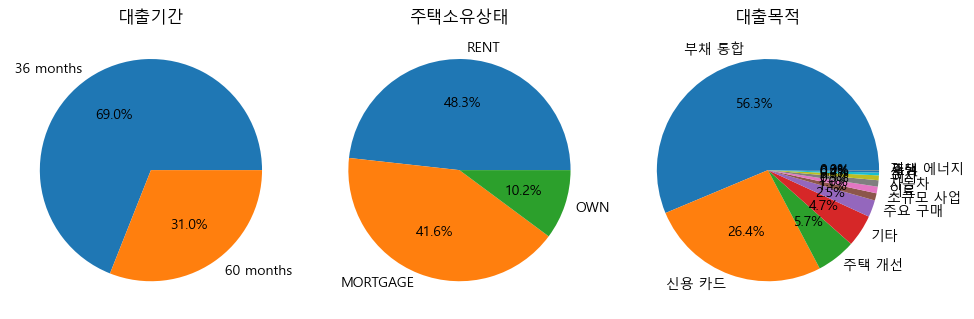

work_year : 4


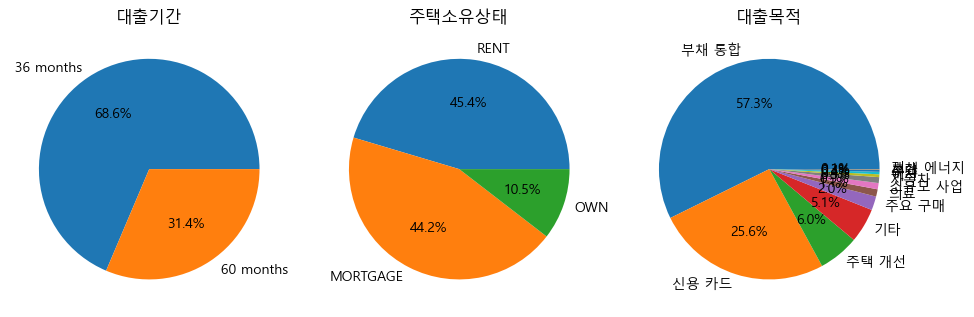

work_year : 5


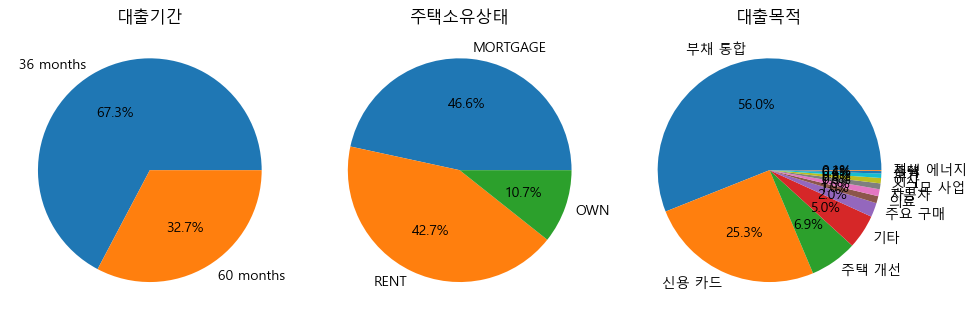

work_year : 6


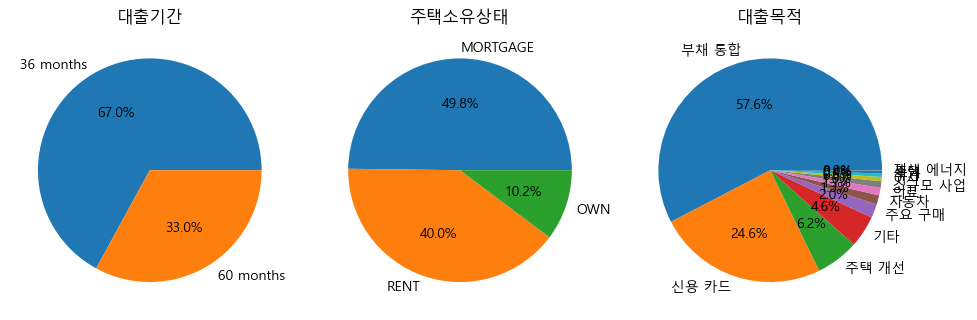

work_year : 7


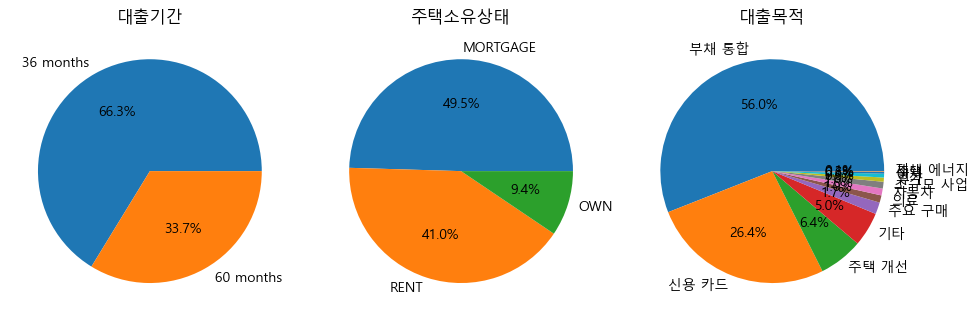

work_year : 8


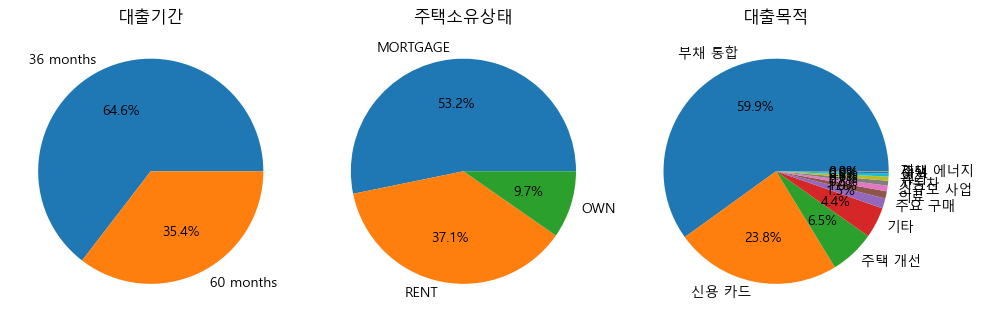

work_year : 9


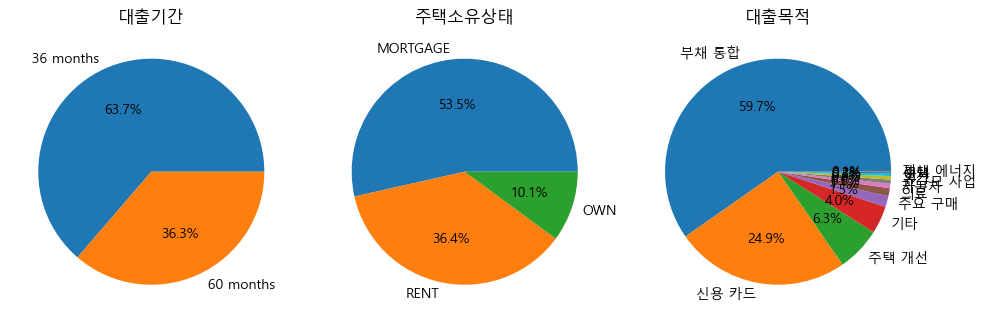

work_year : 10


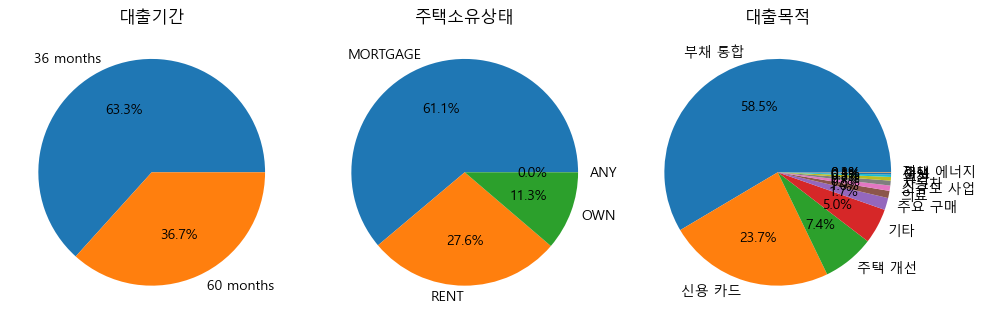

In [39]:
for year in work_year:
    plt.figure(figsize=(10, 30))
    temp = df_n[df_n['근로기간'] == year]
    
    for i, col in enumerate(category_col):
        feature = temp[col]
        data = feature.value_counts()
        
        plt.subplot(1, 3, i+1)
        plt.pie(data.values, labels=data.index, autopct='%.1f%%')
        plt.title(f'{col}')
    
    print(f'work_year : {year}')
    plt.tight_layout()
    plt.show()    
    

In [13]:
df_un.describe(include='all')

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
count,5671,5.671000e+03,5671,5671,5671,5.671000e+03,5671.000000,5671.000000,5671,5671.000000,5.671000e+03,5.671000e+03,5671.000000,5671.000000,5671
unique,5671,NaN,2,1,3,NaN,NaN,NaN,12,NaN,NaN,NaN,NaN,NaN,7
top,TRAIN_00004,NaN,36 months,Unknown,MORTGAGE,NaN,NaN,NaN,부채 통합,NaN,NaN,NaN,NaN,NaN,B
freq,1,NaN,4499,5671,2518,NaN,NaN,NaN,2979,NaN,NaN,NaN,NaN,NaN,1742
mean,NaN,1.409460e+07,NaN,NaN,NaN,6.037176e+07,22.716879,23.909892,NaN,0.280903,6.602966e+05,3.188746e+05,67.875860,0.004056,NaN
std,NaN,8.971980e+06,NaN,NaN,NaN,3.886030e+07,133.884534,11.669062,NaN,0.803818,7.400650e+05,3.535179e+05,1678.686207,0.066278,NaN
min,NaN,1.200000e+06,NaN,NaN,NaN,0.000000e+00,0.000000,4.000000,NaN,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,NaN
25%,NaN,7.200000e+06,NaN,NaN,NaN,3.600000e+07,13.630000,15.000000,NaN,0.000000,2.410380e+05,9.344400e+04,0.000000,0.000000,NaN
50%,NaN,1.200000e+07,NaN,NaN,NaN,5.400000e+07,20.450000,22.000000,NaN,0.000000,4.708440e+05,2.046000e+05,0.000000,0.000000,NaN
75%,NaN,1.875000e+07,NaN,NaN,NaN,7.507102e+07,27.710000,31.000000,NaN,0.000000,8.758920e+05,4.163100e+05,0.000000,0.000000,NaN


### 이상치 제거법

조금 더 데이터를 살펴보고 방법을 정해볼 것.

In [5]:
df['근로기간'].value_counts() / len(df)

10+ years    0.328006
2 years      0.087752
< 1 year     0.080732
3 years      0.078728
1 year       0.064895
Unknown      0.058893
5 years      0.058830
4 years      0.058031
8 years      0.050761
6 years      0.040231
7 years      0.039608
9 years      0.038881
10+years     0.009305
<1 year      0.003842
3            0.000924
1 years      0.000582
Name: 근로기간, dtype: float64

In [114]:
numeric_col = ['대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수']
category_col = ['대출기간', '근로기간', '주택소유상태', '대출목적']

'''
부채_대비_소득_비율 : 4분위수 사용해서 이상치 제거
연간소득 : 4분위수 사용해서 이상치 제거
총상환원금 : 4분위수 사용해서 이상치 제거
총상환이자 : 4분위수 사용해서 이상치 제거
총계좌수 : 4분위수 사용해서 이상치 제거


결측치
근로기간 : unknown = -1
주택소유상태 : any 삭제


인코딩
onehot - 대출기간, 주택소유상태, 대출목적
label - 근로기간





'''

'\n부채_대비_소득_비율 : 4분위수 사용해서 이상치 제거\n연간소득 : 4분위수 사용해서 이상치 제거\n총상환원금 : 4분위수 사용해서 이상치 제거\n총상환이자 : 4분위수 사용해서 이상치 제거\n총계좌수 : 4분위수 사용해서 이상치 제거\n\n\n결측치\n근로기간 : unknown = -1\n주택소유상태 : any 삭제\n\n\n인코딩\nonehot - 대출기간, 주택소유상태, 대출목적\nlabel - 근로기간\n\n\n\n\n\n'

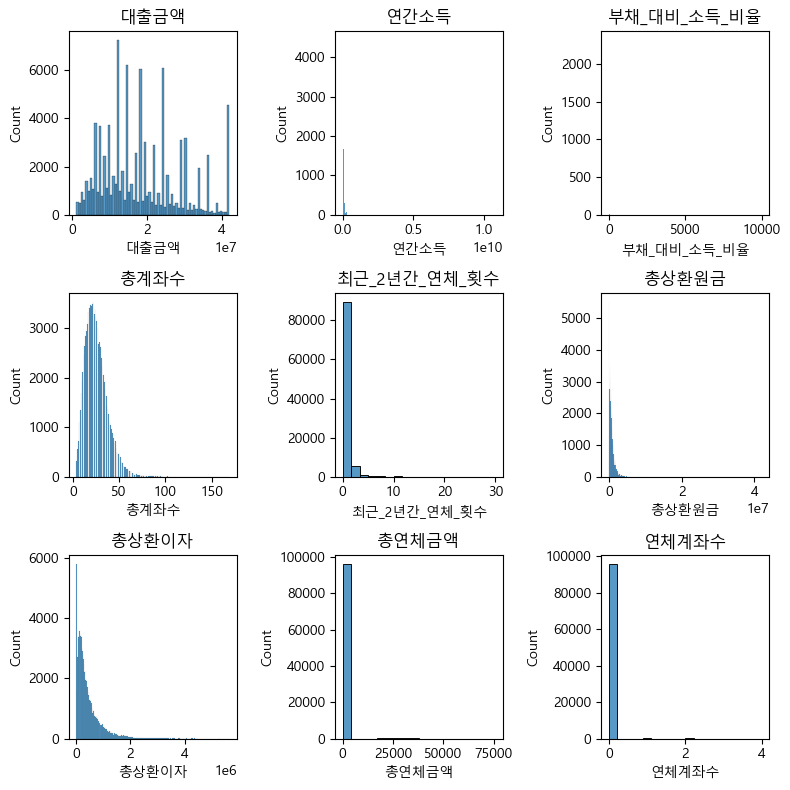

In [68]:
def get_3_hist(data:pd.DataFrame, columns:list):
    
    plt.figure(figsize=(8, 8))

    for i, col in enumerate(columns):
        # 서브플롯 위치 설정
        plt.subplot(3, 3, i + 1)
        # 히스토그램 그리기
        sns.histplot(data[col])
        plt.title(col)

    # 전체 그림 표시
    plt.tight_layout()
    plt.show()

get_3_hist(df, numeric_col)

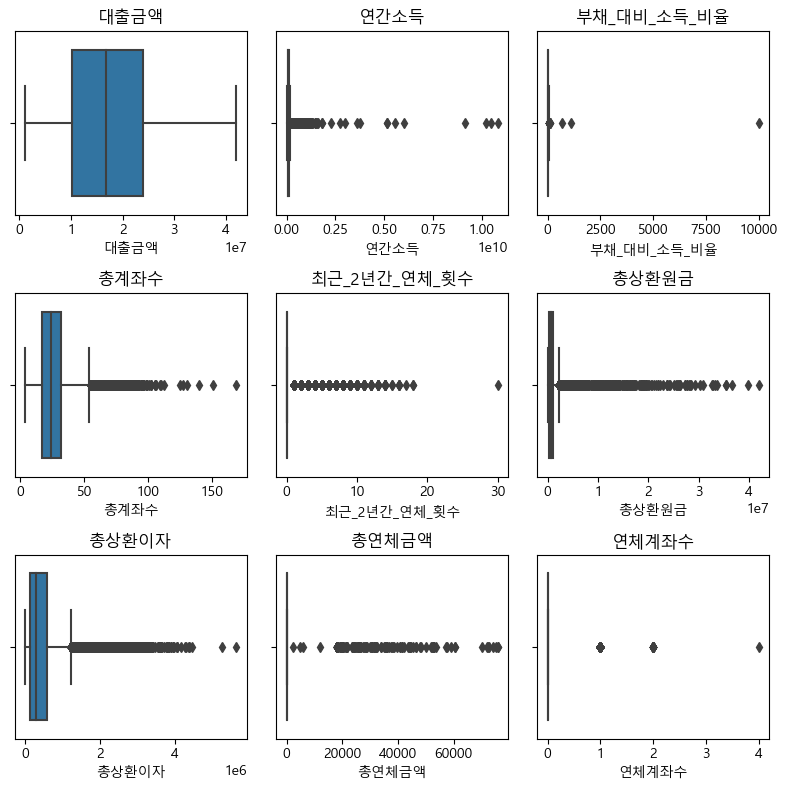

In [69]:
def get_3_box(data:pd.DataFrame, columns:list):
    
    plt.figure(figsize=(8, 8))

    for i, col in enumerate(columns):
        # 서브플롯 위치 설정
        plt.subplot(3, 3, i + 1)
        # 히스토그램 그리기
        sns.boxplot(data[col])
        plt.title(col)

    # 전체 그림 표시
    plt.tight_layout()
    plt.show()

get_3_box(df, numeric_col)

In [115]:
iqr_processing = ['부채_대비_소득_비율', '연간소득', '총상환원금', '총상환이자', '총계좌수']

for col in iqr_processing:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    upper = Q3 + 1.5 * IQR
    lower = Q1 - 1.5 * IQR
    
    condition = (df[col] <= upper) & (df[col] >= lower)
    
    df = df[condition]

In [116]:
log_processing = ['최근_2년간_연체_횟수', '총연체금액']

for col in log_processing:
    df[col] = np.log1p(df[col])

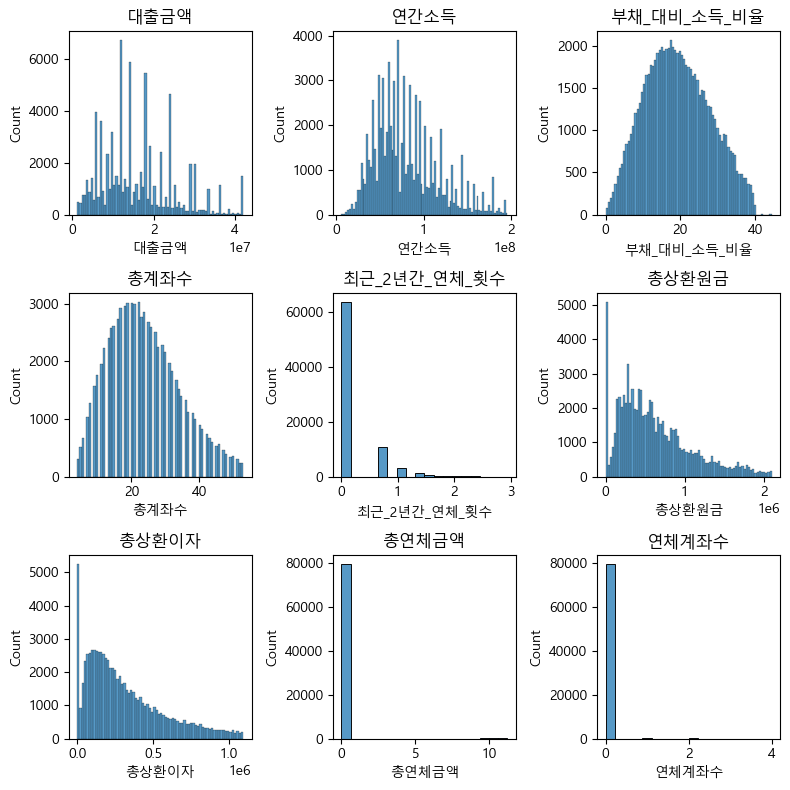

In [72]:
get_3_hist(df, numeric_col)

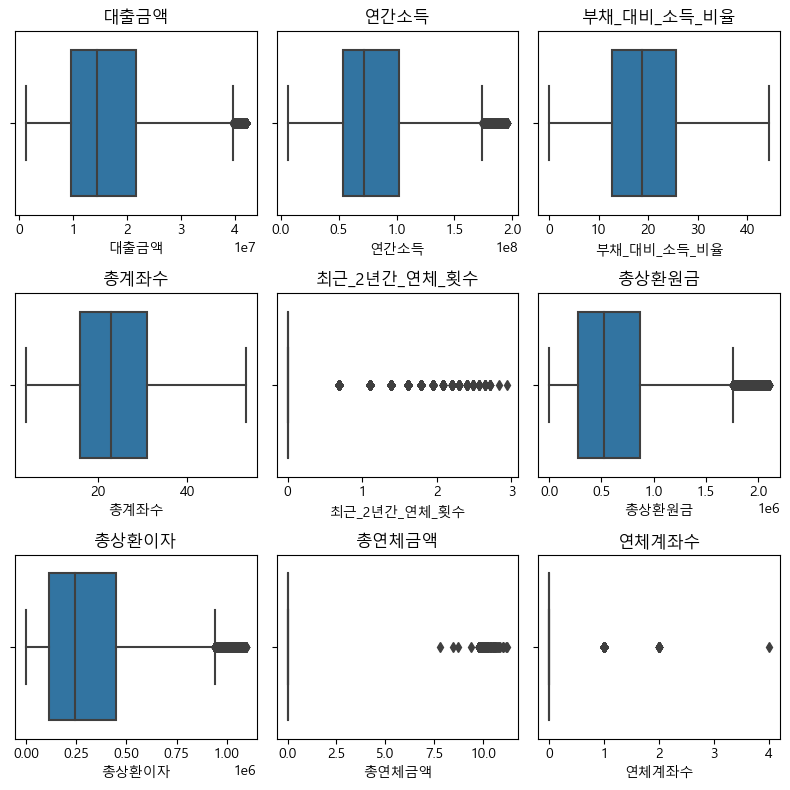

In [73]:
get_3_box(df, numeric_col)

In [74]:
len(df)

79886

In [76]:
for col in df.columns:
    print(col, df[col].unique())

ID ['TRAIN_00000' 'TRAIN_00001' 'TRAIN_00002' ... 'TRAIN_96291' 'TRAIN_96292'
 'TRAIN_96293']
대출금액 [12480000 14400000 12000000 ... 34860000 39060000 38700000]
대출기간 [' 36 months' ' 60 months']
근로기간 ['6 years' '10+ years' '5 years' '8 years' 'Unknown' '9 years' '2 years'
 '3 years' '7 years' '4 years' '< 1 year' '1 year' '10+years' '<1 year'
 '3' '1 years']
주택소유상태 ['RENT' 'MORTGAGE' 'OWN' 'ANY']
연간소득 [ 72000000 130800000  96000000 ...  78602400  83094000  66330000]
부채_대비_소득_비율 [18.9  22.33  8.6  ... 39.07 39.67 39.36]
총계좌수 [15 21 14 19 30 22 45 11 26 24 17 35 20  9 36 16 12 28  8 37 31  6  7 13
 18 42 32 38 43 23 39 33 29 27  5 40 41 25 50 51 52 46 10 47 48 44  4 34
 49 53]
대출목적 ['부채 통합' '주택 개선' '주요 구매' '휴가' '의료' '자동차' '신용 카드' '소규모 사업' '기타' '이사' '주택'
 '재생 에너지']
최근_2년간_연체_횟수 [0.         0.69314718 2.48490665 1.09861229 1.38629436 1.60943791
 1.94591015 1.79175947 2.7080502  2.19722458 2.07944154 2.39789527
 2.63905733 2.30258509 2.56494936 2.83321334 2.94443898]
총상환원금 [      0  373572  92

In [117]:
def year_encoder(x):
    output = x.replace('years', '')
    output = output.replace('year', '')
    output = output.replace('+', '')
    output = output.replace('<', '')
    output = output.replace('Unknown', '-1').strip()
    output = int(output)

    return output

In [118]:
df['근로기간'] = df['근로기간'].apply(year_encoder)

In [119]:
drop_index = df[df['주택소유상태'] == 'ANY'].index

df = df.drop(drop_index)

In [120]:
len(df)

79885

In [81]:
for col in df.columns:
    print(col, df[col].unique())

ID ['TRAIN_00000' 'TRAIN_00001' 'TRAIN_00002' ... 'TRAIN_96291' 'TRAIN_96292'
 'TRAIN_96293']
대출금액 [12480000 14400000 12000000 ... 34860000 39060000 38700000]
대출기간 [' 36 months' ' 60 months']
근로기간 [ 6 10  5  8 -1  9  2  3  7  4  1]
주택소유상태 ['RENT' 'MORTGAGE' 'OWN']
연간소득 [ 72000000 130800000  96000000 ...  78602400  83094000  66330000]
부채_대비_소득_비율 [18.9  22.33  8.6  ... 39.07 39.67 39.36]
총계좌수 [15 21 14 19 30 22 45 11 26 24 17 35 20  9 36 16 12 28  8 37 31  6  7 13
 18 42 32 38 43 23 39 33 29 27  5 40 41 25 50 51 52 46 10 47 48 44  4 34
 49 53]
대출목적 ['부채 통합' '주택 개선' '주요 구매' '휴가' '의료' '자동차' '신용 카드' '소규모 사업' '기타' '이사' '주택'
 '재생 에너지']
최근_2년간_연체_횟수 [0.         0.69314718 2.48490665 1.09861229 1.38629436 1.60943791
 1.94591015 1.79175947 2.7080502  2.19722458 2.07944154 2.39789527
 2.63905733 2.30258509 2.56494936 2.83321334 2.94443898]
총상환원금 [      0  373572  928644 ... 1960620 1481496 1378368]
총상환이자 [     0. 234060. 151944. ... 169680. 620328. 818076.]
총연체금액 [ 0.          9.9893441   9.7981

### 등급별 특징 확인

+ 범주형 변수와 수치형 변수 사이의 관계
+ 수치형 변수들 사이의 관계

In [84]:
for col in category_col:
    print(col)
    display(df[df['대출등급'] == "A"][col].value_counts() / df[df['대출등급'] == "A"][col].value_counts().sum())
    print('----------------------------------')

## 대출기간 : 단기
## 근로기간 : 장기
## 주택상태 : 전세
## 대출목적 : 부채통합

대출기간


 36 months    0.947388
 60 months    0.052612
Name: 대출기간, dtype: float64

----------------------------------
근로기간


 10    0.352420
 1     0.140570
 2     0.086851
 3     0.079472
-1     0.061319
 5     0.060065
 4     0.057040
 8     0.053350
 6     0.037190
 9     0.036231
 7     0.035493
Name: 근로기간, dtype: float64

----------------------------------
주택소유상태


MORTGAGE    0.554604
RENT        0.334785
OWN         0.110611
Name: 주택소유상태, dtype: float64

----------------------------------
대출목적


부채 통합     0.475502
신용 카드     0.384445
주택 개선     0.071207
주요 구매     0.023465
기타        0.022432
자동차       0.011216
의료        0.006789
휴가        0.002656
소규모 사업    0.000959
이사        0.000812
주택        0.000443
재생 에너지    0.000074
Name: 대출목적, dtype: float64

----------------------------------


In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79885 entries, 0 to 96293
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            79885 non-null  object 
 1   대출금액          79885 non-null  int64  
 2   대출기간          79885 non-null  object 
 3   근로기간          79885 non-null  int64  
 4   주택소유상태        79885 non-null  object 
 5   연간소득          79885 non-null  int64  
 6   부채_대비_소득_비율   79885 non-null  float64
 7   총계좌수          79885 non-null  int64  
 8   대출목적          79885 non-null  object 
 9   최근_2년간_연체_횟수  79885 non-null  float64
 10  총상환원금         79885 non-null  int64  
 11  총상환이자         79885 non-null  float64
 12  총연체금액         79885 non-null  float64
 13  연체계좌수         79885 non-null  float64
 14  대출등급          79885 non-null  object 
dtypes: float64(5), int64(5), object(5)
memory usage: 9.8+ MB


In [121]:
from sklearn.model_selection import train_test_split

X = df.drop(['ID', '대출등급'], axis=1)
y = df[['대출등급']]

print(X.shape, y.shape)

(79885, 13) (79885, 1)


In [122]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y['대출등급'])


y['대출등급'] = le.transform(y['대출등급'])
y

,대출등급
0,2
1,1
2,0
3,2
4,1
...,...
96288,2
96290,4
96291,0
96292,3


In [123]:
numeric_col = ['대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수', '근로기간']
category_col = ['대출기간', '주택소유상태', '대출목적']

In [124]:
def numeric_scaler(X):
    
    sc_col = ['최근_2년간_연체_횟수', '총연체금액', '연체계좌수']
    mm_col = ['대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '총상환원금', '총상환이자', '근로기간']
    
    from sklearn.preprocessing import StandardScaler, MinMaxScaler
    
    sc = StandardScaler()
    mm = MinMaxScaler()
    
    X[sc_col] = sc.fit_transform(X[sc_col])
    X[mm_col] = mm.fit_transform(X[mm_col])
    
    return X

X = numeric_scaler(X)

In [125]:
def category_encoder(X:pd.DataFrame):
     X_dummies = pd.get_dummies(X[category_col])
     
     X = pd.concat([X, X_dummies], axis=1)
     
     return X, X_dummies.columns.to_list()

X, dummies_col = category_encoder(X)

In [139]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [157]:
y_val.value_counts()

대출등급
1       5073
2       4796
0       2710
3       2131
4       1014
5        213
6         40
dtype: int64

In [149]:
from sklearn.ensemble import RandomForestClassifier

In [150]:
rfc = RandomForestClassifier(random_state=42)

In [152]:
rfc.fit(X_train[dummies_col + numeric_col], y_train)

RandomForestClassifier(random_state=42)

In [153]:
pred = rfc.predict(X_val[dummies_col + numeric_col])

In [174]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

In [177]:
f1_score(y_val, pred, average='macro')

0.5638020117927778

In [160]:
y_val_dec = le.inverse_transform(y_val['대출등급'])
pred_dec = le.inverse_transform(pred)

In [173]:
testing = le.inverse_transform(np.array([0, 1, 2, 3, 4, 5, 6]))


['A' 'B' 'C' 'D' 'E' 'F' 'G']
['A' 'B' 'C' 'D' 'E' 'F' 'G']


In [161]:
confusion = confusion_matrix(y_val_dec, pred_dec)
confusion

array([[2078,  578,   52,    1,    1,    0,    0],
       [ 231, 4294,  528,   17,    3,    0,    0],
       [  35,  569, 4074,  106,   12,    0,    0],
       [   7,   76,  676, 1273,   99,    0,    0],
       [   3,   12,  131,  387,  477,    3,    1],
       [   0,    0,   20,   38,  117,   38,    0],
       [   0,    0,    4,    7,   14,   14,    1]], dtype=int64)

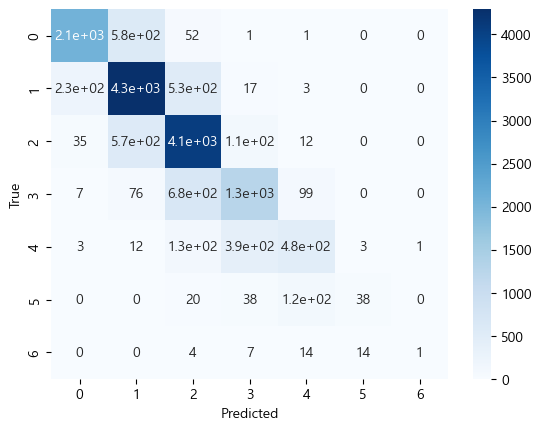

In [163]:
sns.heatmap(confusion, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [178]:
X = df.drop(['ID', '대출등급'], axis=1)
y = df[['대출등급']]

X, dummies_col = category_encoder(X)
X = X.drop(columns=category_col)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y['대출등급'])


y['대출등급'] = le.transform(y['대출등급'])



In [181]:
from imblearn.over_sampling import SMOTE

In [182]:
sm = SMOTE(random_state=42)

X, y = sm.fit_resample(X, y)

In [183]:
X = numeric_scaler(X)

In [184]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [185]:
rfc.fit(X_train[dummies_col + numeric_col], y_train)
pred = rfc.predict(X_val[dummies_col + numeric_col])

In [186]:
f1_score(y_val, pred, average='macro')

0.8759943122057638

In [187]:
confusion = confusion_matrix(y_val_dec, pred_dec)
confusion

array([[2078,  578,   52,    1,    1,    0,    0],
       [ 231, 4294,  528,   17,    3,    0,    0],
       [  35,  569, 4074,  106,   12,    0,    0],
       [   7,   76,  676, 1273,   99,    0,    0],
       [   3,   12,  131,  387,  477,    3,    1],
       [   0,    0,   20,   38,  117,   38,    0],
       [   0,    0,    4,    7,   14,   14,    1]], dtype=int64)

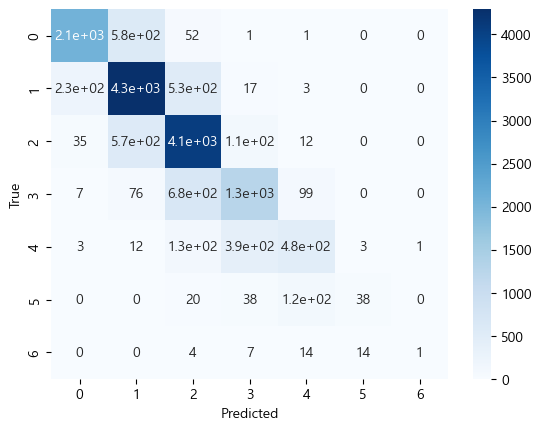

In [188]:
sns.heatmap(confusion, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()